In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = pd.concat([df_train, df_test], axis = 0)

First of all, we examine the dataset for missing values. We print out each column to get a feel for the incompleteness of the data.

In [2]:
print('Missing values per column:')
missing = pd.DataFrame()
for c in range(df_full.shape[1]):
    missing_count = df_full.iloc[:, c].shape[0] - df_full.iloc[:, c].count()  
    if missing_count > 0:
        print(f'{c}:\t{df_full.columns[c]}'
              f' - Missing: {missing_count}'
              f' - # Unique values: {len(df_full.iloc[:, c].value_counts())}')

Missing values per column:
3:	Alley - Missing: 2721 - # Unique values: 2
6:	BsmtCond - Missing: 82 - # Unique values: 4
7:	BsmtExposure - Missing: 82 - # Unique values: 4
8:	BsmtFinSF1 - Missing: 1 - # Unique values: 991
9:	BsmtFinSF2 - Missing: 1 - # Unique values: 272
10:	BsmtFinType1 - Missing: 79 - # Unique values: 6
11:	BsmtFinType2 - Missing: 80 - # Unique values: 6
12:	BsmtFullBath - Missing: 2 - # Unique values: 4
13:	BsmtHalfBath - Missing: 2 - # Unique values: 3
14:	BsmtQual - Missing: 81 - # Unique values: 4
15:	BsmtUnfSF - Missing: 1 - # Unique values: 1135
19:	Electrical - Missing: 1 - # Unique values: 5
23:	Exterior1st - Missing: 1 - # Unique values: 15
24:	Exterior2nd - Missing: 1 - # Unique values: 16
25:	Fence - Missing: 2348 - # Unique values: 4
26:	FireplaceQu - Missing: 1420 - # Unique values: 5
30:	Functional - Missing: 2 - # Unique values: 7
31:	GarageArea - Missing: 1 - # Unique values: 603
32:	GarageCars - Missing: 1 - # Unique values: 6
33:	GarageCond - Missing

34:	GarageFinish - Missing: 159 - # Unique values: 3
35:	GarageQual - Missing: 159 - # Unique values: 5
36:	GarageType - Missing: 157 - # Unique values: 6
37:	GarageYrBlt - Missing: 159 - # Unique values: 103
45:	KitchenQual - Missing: 1 - # Unique values: 4
50:	LotFrontage - Missing: 486 - # Unique values: 128
54:	MSZoning - Missing: 4 - # Unique values: 5
55:	MasVnrArea - Missing: 23 - # Unique values: 444
56:	MasVnrType - Missing: 24 - # Unique values: 4
57:	MiscFeature - Missing: 2814 - # Unique values: 4
66:	PoolQC - Missing: 2909 - # Unique values: 3
70:	SalePrice - Missing: 1459 - # Unique values: 663
71:	SaleType - Missing: 1 - # Unique values: 9
75:	TotalBsmtSF - Missing: 1 - # Unique values: 1058
76:	Utilities - Missing: 2 - # Unique values: 2


There exists a lot of missing values. However, reading the data description, it's clear that the data is very clean and that the missing values are real values not incomplete data. We replace all np.nan values with a placeholder below. The placeholder is 'None' for discrete features or zero for continuous features. We also store the names of continuous and discrete features in order to plot thom.

In [3]:
missing_label = 'None'
cont_feature = []
disc_feature = []
for c in range(df_full.shape[1]):
    if len(pd.value_counts(df_full.iloc[:, c])) > 15 and df_full.iloc[:, c].values.dtype != 'object':
        if df_full.columns[c] not in ('SalePrice', 'Id'):
            df_full.iloc[:, c].fillna(0, inplace = True)
            cont_feature.append(df_full.columns[c])
    else:
        df_full.iloc[:, c].fillna(missing_label, inplace = True)
        disc_feature.append(df_full.columns[c])

We then visualize the relation between each continuous feature and the target variable in order to get a better feel for the data.

/home/mmaesawy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


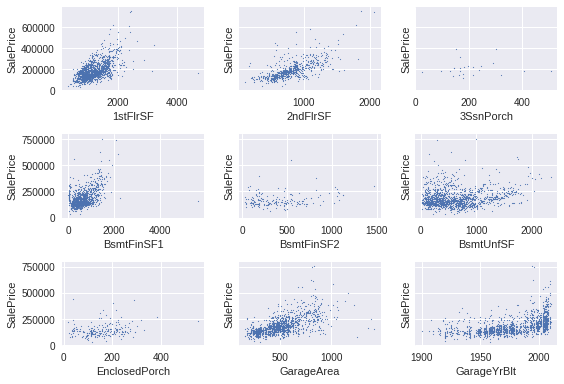

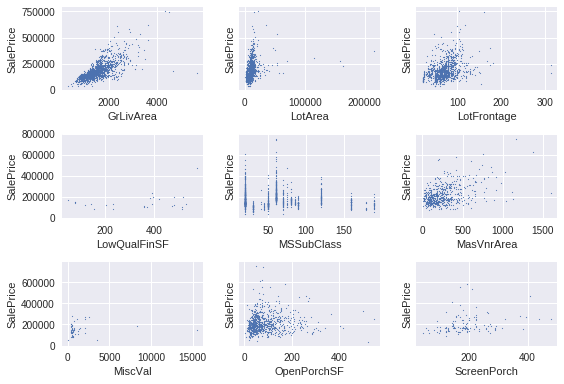

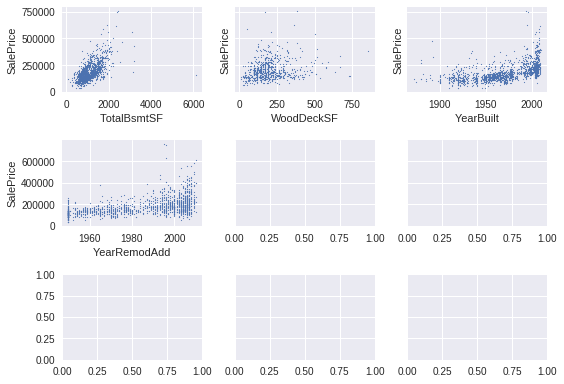

In [4]:
plt.ion()
i = 0
while i < len(cont_feature):
    fig, axs = plt.subplots(nrows = 3,
                            ncols= 3,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(cont_feature): break
        not_na_mask = [x != 0 for x in df_full[cont_feature[i]]]
        ax.scatter(x = df_full[cont_feature[i]].loc[not_na_mask],
                   y = df_full['SalePrice'].loc[not_na_mask],
                   s = 3, marker = '.')
        ax.set_xlabel(cont_feature[i])
        ax.set_ylabel('SalePrice')
        i += 1
    fig.tight_layout()
    fig.show()

We can see from the graphs that most continuous features can be well approximated by a linear function. Features that represent years can be even better approximated with a linear function after applying a square root transformation due to their quadratic curve. We do the same for discrete features, plotting them in box plots to get a better feel for the data. We also convert the labels to numeric ordinal values. In addition, we move the MSSubClass feature to the discrete columns to sort it into ordinal values.

/home/mmaesawy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


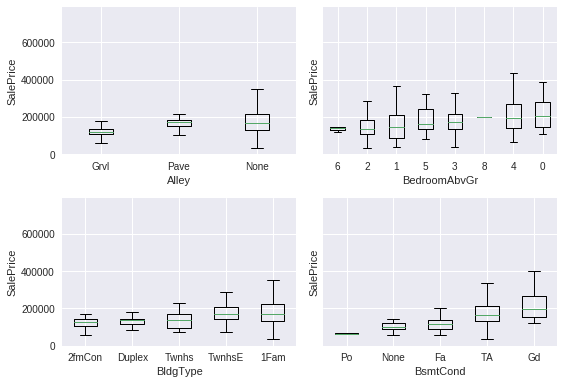

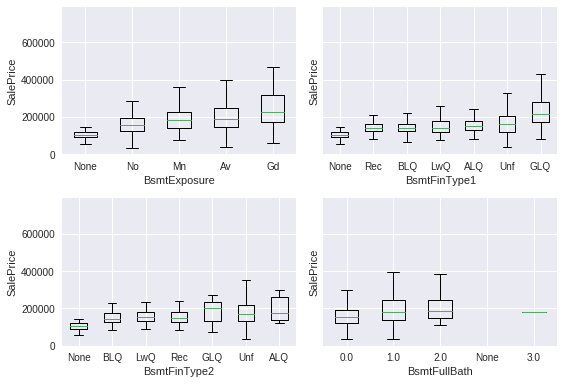

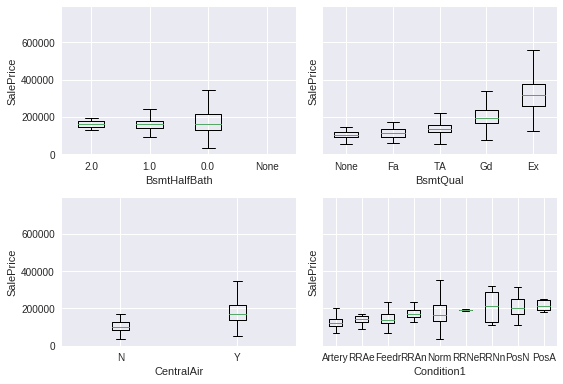

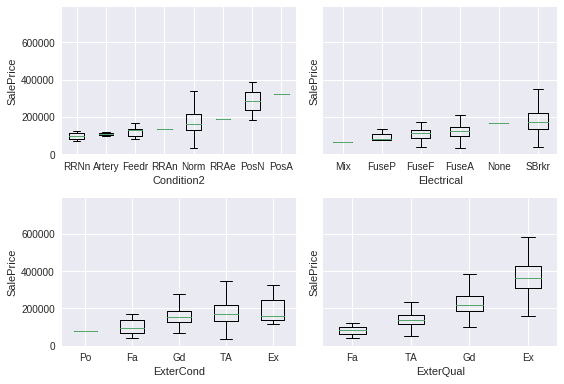

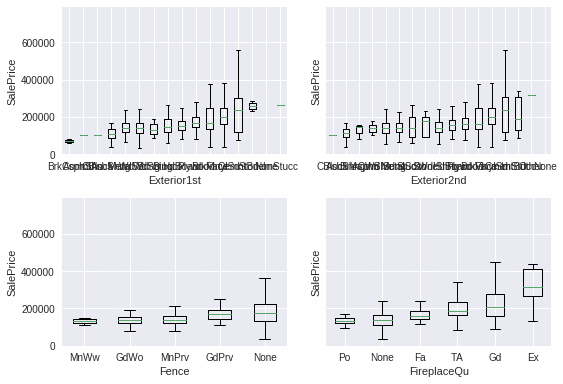

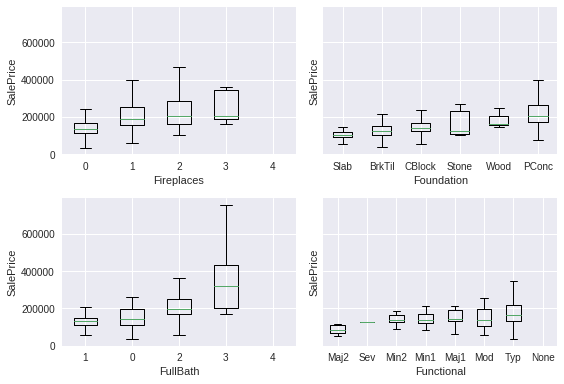

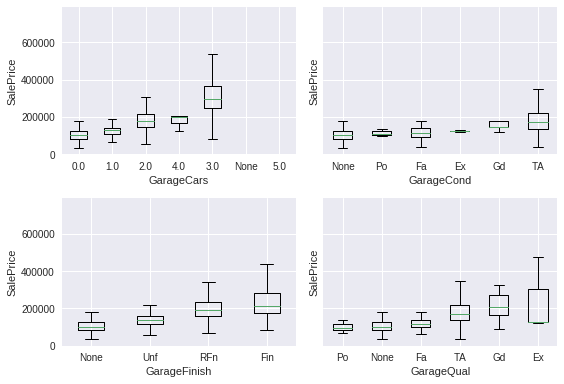

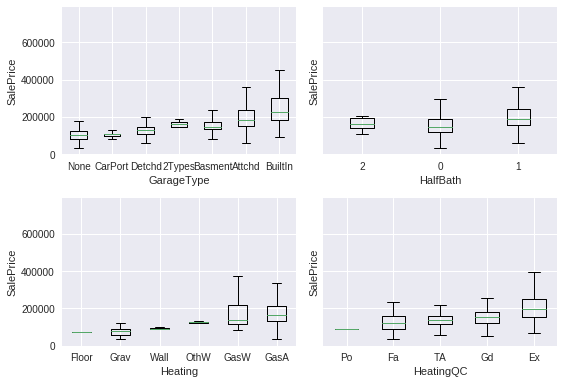

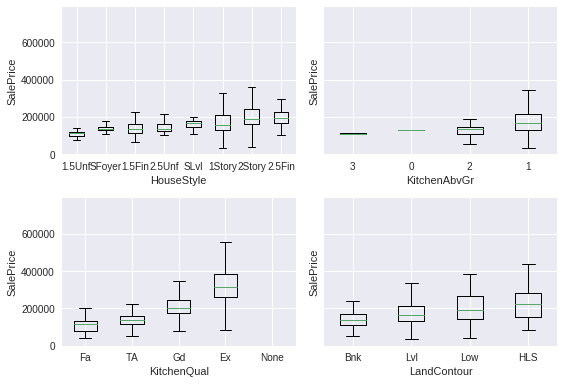

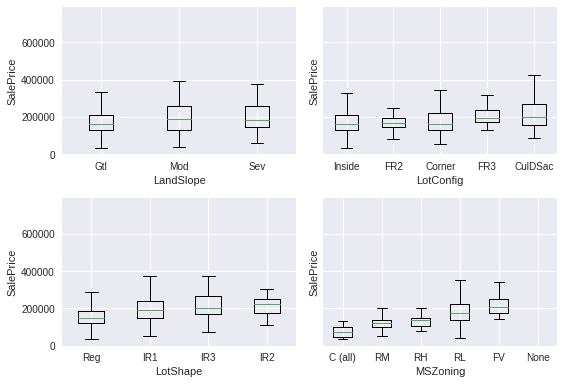

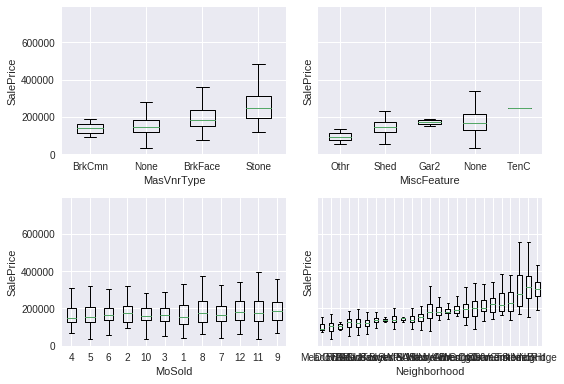

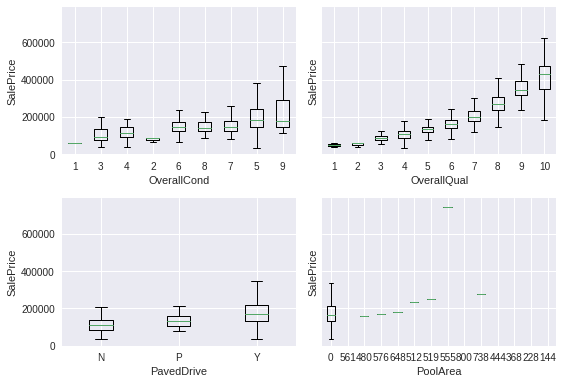

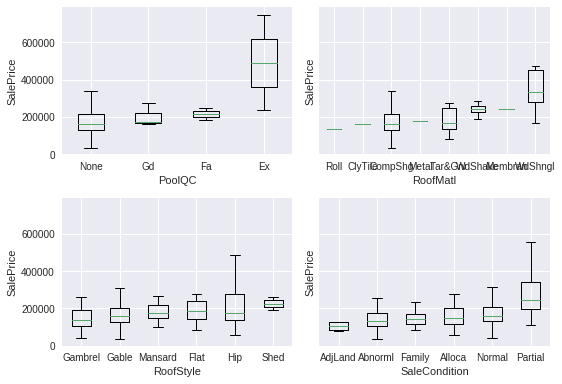

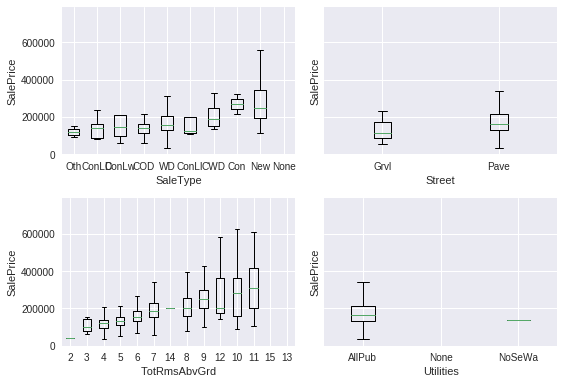

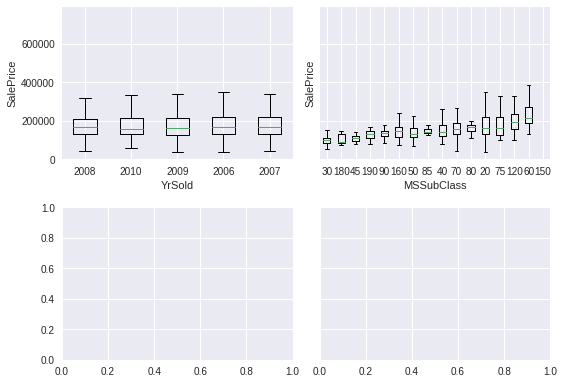

In [5]:
cont_feature.remove('MSSubClass')
disc_feature.append('MSSubClass')
i = 0
while i < len(disc_feature):
    fig, axs = plt.subplots(nrows = 2,
                            ncols= 2,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(disc_feature): break
        categories = df_full[disc_feature[i]].value_counts().index.tolist()
        categories.sort(key = lambda x: df_full['SalePrice'][df_full[disc_feature[i]] == x].mean())
        t = df_full.iloc[:df_train.shape[0], :]
        boxes = [t['SalePrice'][t[disc_feature[i]] == category] for category in categories]
        ax.boxplot(boxes, labels=categories)
        ax.set_xlabel(disc_feature[i])
        ax.set_ylabel('SalePrice')
        
        # Transforming labels into ordinal values sorted according to mean (from above).
        categories = dict(zip(categories, range(len(categories))))
        df_full[disc_feature[i]] = df_full[disc_feature[i]].apply(lambda x: categories[x])
        i += 1
        
    fig.tight_layout()
    fig.show()

Once again, it appears that most features can be modelled with a linear function. We can conclude that a linear model will do well on this data, but we'll try different methods as well just to be sure. We standardize the data and prepare to initially model it without reducing its dimensionality to see how well it will do in its 'default' state.

In [6]:
random_seed = 4057585448 # Random seed for reproducibility.

df_train = df_full.iloc[:df_train.shape[0], :]
df_test = df_full.iloc[df_train.shape[0]+1:, :]

X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Here, we define the loss function we will use to train our model. This is the same loss function used by Kaggle to evaluate our model's performance. 

In [7]:
def log_rmse(ground_truth, predictions):
    predictions = np.abs(predictions)
    return np.sqrt(np.mean(np.power(np.log(predictions) - np.log(ground_truth), 2), axis = 0))
    
log_rmse_l = make_scorer(log_rmse, greater_is_better=False)

We then test our default model and fit it with a Random Forest. Also, to get a reference for how well our model is doing, we calculate the train error we get if we simply predict the mean for each value in target variable. 

In [8]:
print("Error from predicting the mean for all test values:",
      log_rmse(np.mean(y_train) * np.ones(y_train.shape), y_train))

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=5, n_jobs=-1, scoring=log_rmse_l, verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {rf_gs.best_score_}')
print(rf_gs.best_params_)

Error from predicting the mean for all test values: 0.407600507699
Grid searching RF model... 


Best score is -0.14140781952341466
{'max_depth': 21}


<p>Not bad, but we can do better.</p>

<p>Let's try to reduce our data's dimensionality. First, we plot a PCA scree plot to see how well we can do by simply projecting our data to a lower dimension.</p>

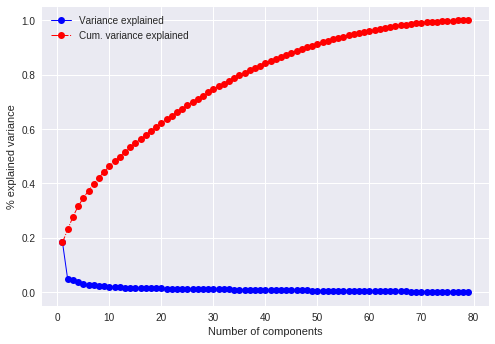

In [9]:
pca = PCA(random_state = random_seed)
pca.fit(X_train)

plt.plot(range(1, X_train.shape[1] + 1),
         pca.explained_variance_ratio_,
         lw=1, color='blue',
         label='Variance explained',
         marker = 'o')
plt.plot(range(1, X_train.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_),
         lw=1, color='red',
         ls='-.', marker = 'o',
         label='Cum. variance explained')
plt.xlabel('Number of components')
plt.ylabel('% explained variance')
plt.legend(loc = 'upper left')
plt.show()

<p>Due to the smoothness of the scree plot, we cannot use PCA to reduce our data's dimensionality (unless we simply use only the first component, ignoring over 80% of the information in our data).</p>

<p>To manually discard useless features, we compute the standard deviation of each feature and print them in a descending order to see which features have very low variability compared to others.</p>

In [10]:
print("Std. for each feature: ")
stds = [(c, df_train.columns[c], df_train.iloc[:, c].std()) for c in range(df_train.shape[1])]
stds.sort(key = lambda x: x[2], reverse = True)
for s in stds:
    print(f'{s[0]}:\t{s[1]}: {s[2]}')

Std. for each feature: 
70:	SalePrice: 79442.50288288663
48:	LotArea: 9981.264932379147
38:	GrLivArea: 525.4803834232027
58:	MiscVal: 496.1230244579311
8:	BsmtFinSF1: 456.09809084092456
37:	GarageYrBlt: 453.6972953893971
15:	BsmtUnfSF: 441.8669552924342
75:	TotalBsmtSF: 438.7053244594705
1:	2ndFlrSF: 436.5284358862591
43:	Id: 421.6100093688479
0:	1stFlrSF: 386.5877380410738
31:	GarageArea: 213.80484145338076
55:	MasVnrArea: 180.73137335812217
9:	BsmtFinSF2: 161.31927280654057
77:	WoodDeckSF: 125.33879435172359
61:	OpenPorchSF: 66.25602767664974
20:	EnclosedPorch: 61.11914860172879
72:	ScreenPorch: 55.757415281874486
52:	LowQualFinSF: 48.623081433519125
50:	LotFrontage: 34.66430423090894
78:	YearBuilt: 30.202904042525265
2:	3SsnPorch: 29.317330556782203
79:	YearRemodAdd: 20.645406807709396
60:	Neighborhood: 6.425884244212347
53:	MSSubClass: 3.884623797213181
59:	MoSold: 3.4192003615624835
24:	Exterior2nd: 3.3576786525637274
23:	Exterior1st: 2.887919828119811
74:	TotRmsAbvGrd: 2.03142925

We discard any feature which has an s.t.d. less than 0.5.

In [11]:
df_train = df_train.drop([s[1] for s in stds if s[2] < 0.5], axis = 1)
df_test = df_test.drop([s[1] for s in stds if s[2] < 0.5], axis = 1)
print(df_train.shape)

(1460, 63)


We display a heatmap to visualize the correlation between each feature.

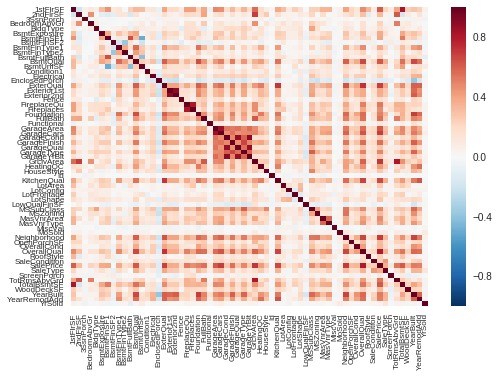

In [12]:
g = sns.heatmap(df_train.corr('pearson'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
sns.plt.show()

We discard any feature that is heavily correlated with another, or is uncorrelated with any other feature. For example YrSold has low correlation with every other feature, including the target variable. And TotalBsmtSF is heavily correlated with 1stFloorSF, so we discard that too.

In [13]:
df_train = df_train.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)
df_test = df_test.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)

We then compute the correlation between the target feature and every other feature to study the importance of each feature in predicting the response.

In [14]:
corr = [(df_train.columns[c], df_train['SalePrice'].corr(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
corr.sort(key = lambda x: x[1], reverse = True)
for c in corr:
    print(c)

('SalePrice', 1.0)
('OverallQual', 0.79098160058380496)
('Neighborhood', 0.69688223975679076)
('ExterQual', 0.68263924165625978)
('KitchenQual', 0.65959972072866258)
('GarageArea', 0.62343143891836195)
('BsmtQual', 0.62292472605884197)
('1stFlrSF', 0.6058521846919146)
('FullBath', 0.55385145575505834)
('TotRmsAbvGrd', 0.53767185987331279)
('YearBuilt', 0.52289733287949702)
('YearRemodAdd', 0.5071009671113863)
('Foundation', 0.50550317128974476)
('GarageType', 0.48912998736755348)
('MSSubClass', 0.47698243019657593)
('MasVnrArea', 0.47261449900457392)
('Fireplaces', 0.46692883675152763)
('HeatingQC', 0.42764870739880351)
('MasVnrType', 0.42369742479035416)
('BsmtFinSF1', 0.38641980624215327)
('BsmtFinType1', 0.38096429719017377)
('BsmtExposure', 0.37469622100088673)
('Exterior1st', 0.37145074216158619)
('SaleType', 0.3668207372968007)
('OverallCond', 0.33036410724017512)
('MSZoning', 0.32460953442313278)
('WoodDeckSF', 0.32441344456813004)
('2ndFlrSF', 0.31933380283206786)
('OpenPorchSF

We drop every feature that has an absolute correlation of less the 0.2 with that response.

In [15]:
df_train = df_train.drop([c[0] for c in corr if math.fabs(c[1]) < 0.2], axis = 1)
df_test = df_test.drop([c[0] for c in corr if math.fabs(c[1]) < 0.2], axis = 1)

To get rid of outliers in our data, we standardize the data and ditch any observation with a varible with a Z-score of over 4.0 (approximately 0.9999% of the two-sided area under the normal curve).

In [16]:
df_train_std = sc.fit_transform(df_train)
drop_indices = []
for i in range(df_train.shape[0]):
    for j in df_train_std[i, :]:
        if j > 4.0:
            drop_indices.append(i)
df_train.drop(drop_indices, axis = 0, inplace = True)
print(df_train.shape)

(1410, 40)


We transform any year features we have using a square root function.

In [17]:
p = re.compile('(Yr)|(Year)')
for c in range(df_train.shape[1]):
    if p.search(df_train.columns[c]):
        df_train.iloc[:, c] = np.sqrt(df_train.iloc[:, c].values)

Finally, we search for the best model that represents our data.

In [18]:
X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)  

print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=GradientBoostingRegressor(),
                      param_grid=[{'learning_rate': [x / 100 for x in range(5, 20, 1)],
                                   'max_depth': [x for x in range(2, 7)],
                                   'max_features': [x / 10 for x in range(1, 11)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {gb_gs.best_score_}')
print(gb_gs.best_params_)
print()

print("Grid searching AB model...")
ad_gs = GridSearchCV(cv=5, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=AdaBoostRegressor(base_estimator=LinearRegression(),
                                                  random_state=random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(85, 115, 1)]}])
ad_gs.fit(X_train, y_train)
print(f'Best score is {ad_gs.best_score_}')
print(ad_gs.best_params_)
print()

print("Grid searching bagging model...")
bag_gs = GridSearchCV(cv=10, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=BaggingRegressor(base_estimator = LinearRegression(),
                                                 n_estimators = 25),
                      param_grid=[{'max_features': [x / 100 for x in range(50, 101, 1)]}])
bag_gs.fit(X_train, y_train)
print(f'Best score is {bag_gs.best_score_}')
print(bag_gs.best_params_)
print()

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=10, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(1, 1000, 10)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {lasso_gs.best_score_}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(0, 1000, 10)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {ridge_gs.best_score_}')
print(ridge_gs.best_params_)
print()

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=10, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {rf_gs.best_score_}')
print(rf_gs.best_params_)

print("Grid searching KNN model... ")
knn_gs = GridSearchCV(cv=10, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=KNeighborsRegressor(),
                      param_grid=[{'n_neighbors': [x for x in range(3, 80)],
                                   'weights': ['uniform', 'distance']}])
knn_gs.fit(X_train, y_train)
print(f'Best score is {knn_gs.best_score_}')
print(knn_gs.best_params_)

Grid searching GB model...
Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.4s


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min


[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.7min


[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min


[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.0min


[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.8min


[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 15.3min


[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed: 18.6min finished


Best score is -0.12350714734696651
{'learning_rate': 0.09, 'max_depth': 4, 'max_features': 0.3}

Grid searching AB model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   25.3s finished


Best score is -0.19001231856274492
{'learning_rate': 1.05}

Grid searching bagging model...
Fitting 10 folds for each of 51 candidates, totalling 510 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min


[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:  2.9min finished


Best score is -0.14365102661604967
{'max_features': 0.51}

Grid searching lasso model...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.2s


[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   13.9s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.7s finished


Best score is -0.1478694473126195
{'alpha': 991}

Grid searching ridge model...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    1.8s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.5s finished


Best score is -0.14481602755055523
{'alpha': 380}

Grid searching RF model... 
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.0min


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.4min finished


Best score is -0.1354501344464708
{'max_depth': 20}
Grid searching KNN model... 
Fitting 10 folds for each of 154 candidates, totalling 1540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.6s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.4s


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min


[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.7min


[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min


Best score is -0.15611104567182116
{'n_neighbors': 13, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 1540 out of 1540 | elapsed:  7.2min finished


Evidently, the best model is a gradient boosting model with a learning rate of 0.09, max depth of 4, and max features of 0.3. We search further around these parameters to get an even better model.

In [21]:
print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=10, n_jobs=-1, scoring=log_rmse_l, verbose=1,
                      estimator=GradientBoostingRegressor(max_depth = 4, random_state = random_seed),
                      param_grid=[{'learning_rate': [x / 1000 for x in range(80, 100, 1)],
                                   'max_features': [x / 100 for x in range(25, 35)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {gb_gs.best_score_}')
print(gb_gs.best_params_)
print()

Grid searching GB model...
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.1s


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min


[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min


[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min


[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.0min


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  7.1min finished


Best score is -0.12310325893166005
{'learning_rate': 0.097, 'max_features': 0.29}



So now that we know our optimal hyperparamters, we train the model on the full dataset, predict the target using the test data, and output them to a .csv file.

In [25]:
gb = GradientBoostingRegressor(learning_rate=0.97,
                               max_features = 0.29,
                               max_depth = 4,
                               random_state = random_seed)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
output = pd.concat([pd.read_csv('test.csv')['Id'], pd.Series(y_pred)], axis = 1)
output.columns = ['Id', 'SalePrice']
output.to_csv('submissions.csv', index = False)